## Get (bugs) information from `.csv` files

The following part extracts information from the `.csv` files dumped during running test suites on DBMSs.

In [182]:
import pandas as pd
import re

db = "cockroachdb"
results_df = pd.read_csv(f"output/{db}_results.csv")
logs_df = pd.read_csv(f"output/{db}_logs.csv")
#results_df = pd.read_csv("final_outputs/cockroachdb_results.csv")
#logs_df = pd.read_csv("final_outputs/cockroachdb_logs.csv")

print(results_df.info())
print(logs_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       9999 non-null   int64  
 1   DBMS_NAME        9999 non-null   object 
 2   TESTFILE_INDEX   9999 non-null   int64  
 3   TESTFILE_PATH    9999 non-null   object 
 4   ORIGINAL_SUITE   0 non-null      float64
 5   TESTCASE_INDEX   9999 non-null   int64  
 6   SQL              9999 non-null   object 
 7   CASE_TYPE        9999 non-null   object 
 8   EXPECTED_RESULT  4899 non-null   object 
 9   ACTUAL_RESULT    9638 non-null   object 
 10  EXEC_TIME        9999 non-null   int64  
 11  DATE             9999 non-null   object 
 12  IS_ERROR         9999 non-null   bool   
 13  ERROR_MSG        6402 non-null   object 
 14  USER             9999 non-null   object 
 15  LOGS_INDEX       9999 non-null   int64  
dtypes: bool(1), float64(1), int64(5), object(9)
memory usage: 1.

In [183]:
results_df['USER'].unique()

array(['root', 'testuser'], dtype=object)

In [184]:
from random import randint

bug_rows = results_df.loc[results_df.IS_ERROR == True]

print(bug_rows)
print(logs_df.LOGS)

bug_row = bug_rows.sample(0).squeeze()
dbms_name = bug_row.DBMS_NAME
log_row = logs_df.loc[bug_row.LOGS_INDEX]
test_suite = 'cockroachdb'  # TODO same as above


      Unnamed: 0    DBMS_NAME  TESTFILE_INDEX                               TESTFILE_PATH  ORIGINAL_SUITE  TESTCASE_INDEX                                                                                   SQL  CASE_TYPE                                                         EXPECTED_RESULT ACTUAL_RESULT  EXEC_TIME            DATE  IS_ERROR                                              ERROR_MSG  USER  LOGS_INDEX
5147          14  cockroachdb             161  cockroachdb_tests/logic_test/rename_column             NaN              21                                             ALTER TABLE users RENAME COLUMN id TO uid  Statement               cannot rename column "id" because view "v2" depends on it          True      87295  23-03-16-11:36      True                                                   None  root           0
6893          24  cockroachdb             219    cockroachdb_tests/logic_test/rename_view             NaN              31                                                A

In [185]:
print("Total number of tested files: " , len(results_df['TESTFILE_INDEX'].unique()))
print("Total number of executed test cases", len(results_df))
print("Total number of files with errors: ", len(bug_rows['TESTFILE_INDEX'].unique()))
print("Total number of errors: ", len(bug_rows['ERROR_MSG']))
print("Total number of unique error messages: ", len(bug_rows['ERROR_MSG'].unique()))
value_mismatch = bug_rows[bug_rows['ERROR_MSG'] == 'Result MisMatch']
print("Total number of result mismatch ", len(value_mismatch))
'''
run 1
Total number of tested files:  301
Total number of files with errors:  241
Total number of errors:  3044
Total number of unique error messages:  569
Total number of result mismatch  883

#After filter
Total number of tested files:  274
Total number of files with errors:  30
Total number of errors:  139
Total number of unique error messages:  60
Total number of result mismatch  39


Total number of tested files:  304
Total number of executed test cases 12110
Total number of files with errors:  186
Total number of errors:  1877
Total number of unique error messages:  185
Total number of result mismatch  771

After filter
Total number of tested files:  301
Total number of executed test cases 10110
Total number of files with errors:  34
Total number of errors:  111
Total number of unique error messages:  38
Total number of result mismatch  56

After filter 2
Total number of tested files:  300
Total number of executed test cases 9999
Total number of files with errors:  2
Total number of errors:  6
Total number of unique error messages:  5
Total number of result mismatch  1

After fixing row wise compare:

'''


Total number of tested files:  300
Total number of executed test cases 9999
Total number of files with errors:  2
Total number of errors:  6
Total number of unique error messages:  5
Total number of result mismatch  1


'\nrun 1\nTotal number of tested files:  301\nTotal number of files with errors:  241\nTotal number of errors:  3044\nTotal number of unique error messages:  569\nTotal number of result mismatch  883\n\n#After filter\nTotal number of tested files:  274\nTotal number of files with errors:  30\nTotal number of errors:  139\nTotal number of unique error messages:  60\nTotal number of result mismatch  39\n\n\nTotal number of tested files:  304\nTotal number of executed test cases 12110\nTotal number of files with errors:  186\nTotal number of errors:  1877\nTotal number of unique error messages:  185\nTotal number of result mismatch  771\n\nAfter filter\nTotal number of tested files:  301\nTotal number of executed test cases 10110\nTotal number of files with errors:  34\nTotal number of errors:  111\nTotal number of unique error messages:  38\nTotal number of result mismatch  56\n'

In [186]:
#print(bug_rows[['EXPECTED_RESULT','ACTUAL_RESULT']].value_counts())
print(bug_rows[['ERROR_MSG']].value_counts())


ERROR_MSG                                            
None                                                     2
Execution Failed: relation "test.v2" does not exist\n    1
Result MisMatch                                          1
relation "test.public.v" already exists\n                1
relation "test.v2" does not exist\n                      1
dtype: int64


In [188]:
print(bug_rows['TESTFILE_PATH'].value_counts())


cockroachdb_tests/logic_test/rename_view      5
cockroachdb_tests/logic_test/rename_column    1
Name: TESTFILE_PATH, dtype: int64


In [181]:
#print(bug_rows['TESTFILE_PATH'].value_counts())

print(bug_rows[['ACTUAL_RESULT', 'EXPECTED_RESULT']].head())
#69

    ACTUAL_RESULT EXPECTED_RESULT
365         False             NaN
658         False             NaN
748         False             NaN
749         False             NaN
851         False             NaN


## Reproduce an error testcase

The following code picks a bug record in the `.csv` file and run on the selected db. Maybe running using the testrunner.

In [98]:
from src import testrunner

if dbms_name == 'sqlite':
    r = testrunner.SQLiteRunner()
elif dbms_name == 'duckdb':
    r = testrunner.DuckDBRunner()
elif dbms_name == 'cockroachdb':
    r = testrunner.CockroachDBRunner()
elif dbms_name == 'mysql':
    r = testrunner.MySQLRunner()
else:
    exit("Not implement yet")
r

In [99]:
r.set_db("test")

OperationalError: connection to server at "localhost" (::1), port 26257 failed: ERROR:  server is not accepting clients, try another node


In [128]:
r.connect("test")
bug_row = value_mismatch.iloc[0]

print(bug_row)
print(log_row)
print(log_row.LOGS)
r.executemany_stmt(log_row.LOGS)

print("The Fault SQL is %s" % bug_row.SQL)
print("The Expected Result is:")
print(bug_row.EXPECTED_RESULT)
print("The Actual Result is:")
result = r.execute_query(bug_row.SQL)
for row in result:
    for item in row:
        print(item)






Unnamed: 0                                                                                                                         12
DBMS_NAME                                                                                                                 cockroachdb
TESTFILE_INDEX                                                                                                                      3
TESTFILE_PATH                                                                                cockroachdb_tests/logic_test/show_create
ORIGINAL_SUITE                                                                                                                    NaN
TESTCASE_INDEX                                                                                                                     12
SQL                                                                                                                     SHOW CREATE c
CASE_TYPE                                                     

AttributeError: 'NoneType' object has no attribute 'execute'

In [129]:
import numpy as np
errors = bug_rows.dropna(subset = ['ERROR_MSG']).ERROR_MSG.unique()


print(type(errors))
print(errors.shape)
errors = np.array(pd.Series(errors).str.replace( 'Parser Error:', ''))
errors = np.array(pd.Series(errors).str.replace( 'Catalog Error:', ''))

print(errors)

<class 'numpy.ndarray'>
(569,)
['Execution Failed: relation "xyz" does not exist\n'
 'relation "xz" does not exist\n'
 'unique constraints without an index are not yet supported\n'
 'Result MisMatch'
 'constraint "unique_b" of relation "c" does not exist\n'
 'constraint "unique_b_partial" of relation "c" does not exist\n'
 'prepared statement "x" does not exist\n'
 'current transaction is aborted, commands ignored until end of transaction block\n'
 'relation "defaultdb.public.t" already exists\n'
 'too many columns in RELOCATE data\n'
 'too many columns in RELOCATE LEASE data\n'
 'too many columns in SPLIT AT data\n'
 'error looking up store 3: KeyNotPresentError: gossip key "store:3" does not exist or has expired\n'
 'column "v" does not exist\n'
 'Execution Failed: index "idx" does not exist\n'
 'index "idx" does not exist\n'
 'Execution Failed: column "name" does not exist\n'
 'at or near "tenant": syntax error\nDETAIL:  source SQL:\nCREATE TENANT "tenant-one"\n       ^\nHINT:  try 

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer
def cluster_text(text):
    vectorizer = TfidfVectorizer(stop_words={'english'})
    X = vectorizer.fit_transform(text)

    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    true_k = 7
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    for i in range(true_k):
        print(clusters[clusters['cluster'] == i])
        
    return clusters

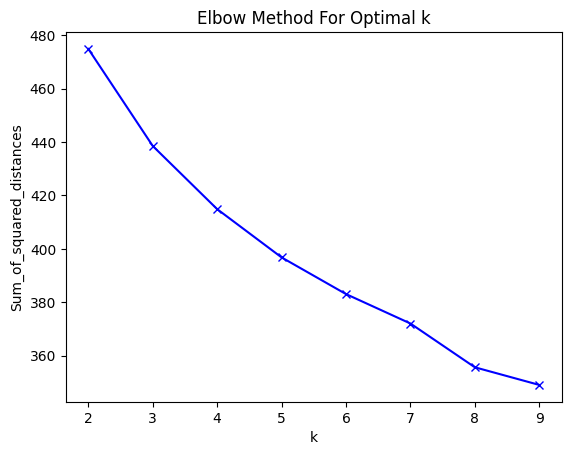

                                                                                                                  title  cluster
29               duplicate key value violates unique constraint "t2_pkey"\nDETAIL:  Key (d,v)=(3,3.0) already exists.\n        0
57         duplicate key value violates unique constraint "data_pkey"\nDETAIL:  Key (a,b,c)=(1,1,1.0) already exists.\n        0
59                     duplicate key value violates unique constraint "t_pkey"\nDETAIL:  Key (id)=(1) already exists.\n        0
60                     duplicate key value violates unique constraint "t_pkey"\nDETAIL:  Key (id)=(2) already exists.\n        0
70                duplicate key value violates unique constraint "abc_pkey"\nDETAIL:  Key (a,c)=(2,1) already exists.\n        0
71                duplicate key value violates unique constraint "abc_pkey"\nDETAIL:  Key (a,c)=(2,2) already exists.\n        0
72                     duplicate key value violates unique constraint "kv_pkey"\nDETAIL:  Key (k)

In [131]:
x = cluster_text(errors)

In [132]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:120% !important; }</style>"))

In [140]:
with pd.option_context('display.max_colwidth', None):
    print(x['title'][x['cluster'] == 6])


6                                    prepared statement "x" does not exist\n
103                Execution Failed: prepared statement "z" does not exist\n
105          Execution Failed: prepared statement "ctestmt" does not exist\n
159                Execution Failed: prepared statement "a" does not exist\n
160                Execution Failed: prepared statement "b" does not exist\n
162         Execution Failed: prepared statement "alltypes" does not exist\n
163                Execution Failed: prepared statement "i" does not exist\n
164                Execution Failed: prepared statement "s" does not exist\n
165    Execution Failed: prepared statement "groupbyhaving" does not exist\n
166               Execution Failed: prepared statement "p1" does not exist\n
167               Execution Failed: prepared statement "p2" does not exist\n
168               Execution Failed: prepared statement "p3" does not exist\n
169             Execution Failed: prepared statement "setp" does not exist\n